(tut_three)=

# **Partial Network Quantization: Specific Layer Class**

```{eval-rst}

.. admonition:: Goal
    :class: note

    #. Take a resnet-like model and train on cifar10 dataset.
    #. Quantize only 'Dense' layer class.
    #. Fine-tune to recover model accuracy.
    #. Save both original and quantized model while performing ONNX conversion.

```

```{eval-rst}

.. admonition:: Background
    :class: tip

    Specific layer classes to quantize are passed to `quantize_model()` via a `QuantizationSpec` object.
    For layer `l`, the class name can be found using `l.__class__.__name__`. </br>

```
Refer to the [Python API](qmodel_api) documentation for more details.

---

In [1]:
#
# SPDX-FileCopyrightText: Copyright (c) 1993-2022 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
# SPDX-License-Identifier: Apache-2.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

import tensorflow as tf
from tensorflow_quantization import quantize_model, QuantizationSpec
import tiny_resnet
from tensorflow_quantization import utils
import os

tf.keras.backend.clear_session()

# Create folders to save TF and ONNX models
assets = utils.CreateAssetsFolders(os.path.join(os.getcwd(), "tutorials"))
assets.add_folder("simple_network_quantize_specific_class")

In [2]:
# Load CIFAR10 dataset
cifar10 = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize the input image so that each pixel value is between 0 and 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

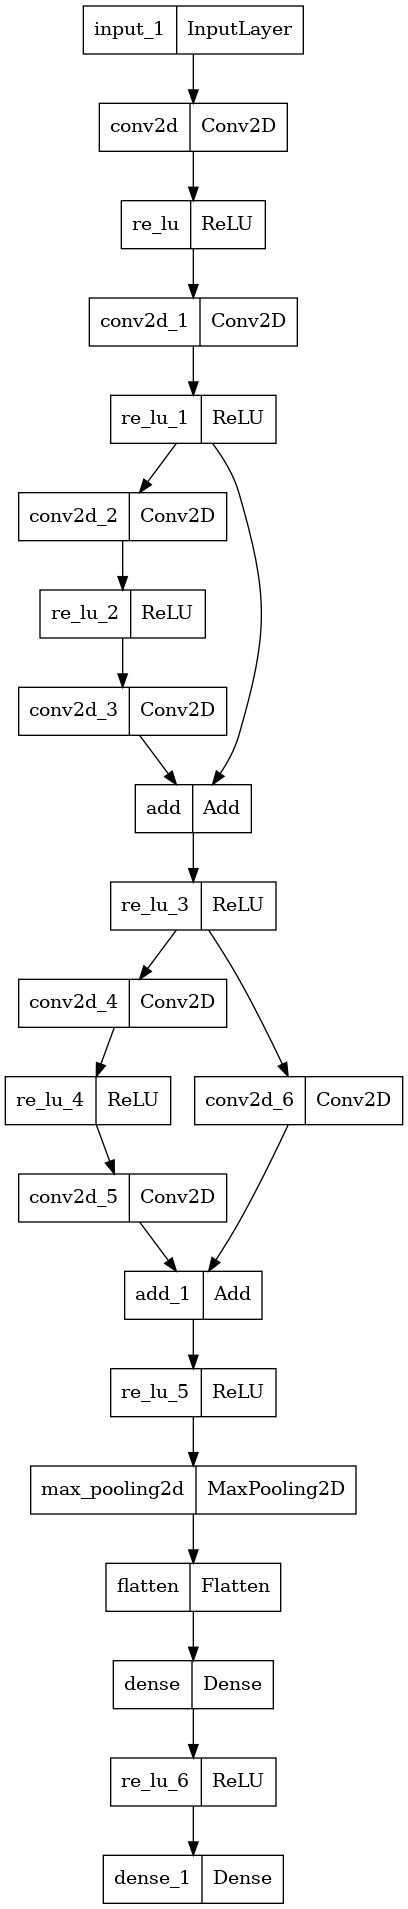

In [3]:
nn_model_original = tiny_resnet.model()
tf.keras.utils.plot_model(nn_model_original, to_file = assets.simple_network_quantize_specific_class.fp32 + "/model.png")

In [4]:
# Train original classification model
nn_model_original.compile(
    optimizer=tiny_resnet.optimizer(lr=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

_ = nn_model_original.fit(
    train_images, train_labels, batch_size=32, epochs=10, validation_split=0.1
)


Epoch 1/10
1407/1407 [==============================] - 17s 10ms/step - loss: 1.7871 - accuracy: 0.3526 - val_loss: 1.5601 - val_accuracy: 0.4448
Epoch 2/10
1407/1407 [==============================] - 14s 10ms/step - loss: 1.4970 - accuracy: 0.4641 - val_loss: 1.4441 - val_accuracy: 0.4812
Epoch 3/10
1407/1407 [==============================] - 13s 9ms/step - loss: 1.3885 - accuracy: 0.5040 - val_loss: 1.3627 - val_accuracy: 0.5178
Epoch 4/10
1407/1407 [==============================] - 13s 10ms/step - loss: 1.3101 - accuracy: 0.5347 - val_loss: 1.3018 - val_accuracy: 0.5332
Epoch 5/10
1407/1407 [==============================] - 13s 9ms/step - loss: 1.2473 - accuracy: 0.5591 - val_loss: 1.2233 - val_accuracy: 0.5650
Epoch 6/10
1407/1407 [==============================] - 14s 10ms/step - loss: 1.1926 - accuracy: 0.5796 - val_loss: 1.2065 - val_accuracy: 0.5818
Epoch 7/10
1407/1407 [==============================] - 14s 10ms/step - loss: 1.1475 - accuracy: 0.5972 - val_loss: 1.1449 - v

In [5]:
# Get baseline model accuracy
_, baseline_model_accuracy = nn_model_original.evaluate(
    test_images, test_labels, verbose=0
)
baseline_model_accuracy = round(100 * baseline_model_accuracy, 2)
print("Baseline FP32 model test accuracy:", baseline_model_accuracy)

Baseline FP32 model test accuracy: 61.51


In [6]:
# Save TF FP32 original model
tf.keras.models.save_model(nn_model_original, assets.simple_network_quantize_specific_class.fp32_saved_model)

# Convert FP32 model to ONNX
utils.convert_saved_model_to_onnx(saved_model_dir = assets.simple_network_quantize_specific_class.fp32_saved_model, onnx_model_path = assets.simple_network_quantize_specific_class.fp32_onnx_model)


INFO:tensorflow:Assets written to: /home/sagar/nvidia/2021/Customers/Waymo/QAT/tensorrt_qat/docs/source/notebooks/tutorial_onnx_models/simple_network_quantize_specific_class/fp32/saved_model/assets
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
ONNX conversion Done!


In [7]:
# Quantize model
# 1.1 Create a list with keras layer classes to quantize
qspec = QuantizationSpec()
qspec.add(name="Dense", is_keras_class=True)
# 1.2 Call quantize model function
q_nn_model = quantize_model(model=nn_model_original, quantization_mode='partial', quantization_spec=qspec)

q_nn_model.compile(
    optimizer=tiny_resnet.optimizer(lr=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

[I] Layer class `Conv2D` is not quantized. Partial quantization is enabled and layer class is not in user provided QuantizationSpec class object
[I] Layer class `ReLU` is not quantized. Partial quantization is enabled and layer class is not in user provided QuantizationSpec class object
[I] Layer class `Conv2D` is not quantized. Partial quantization is enabled and layer class is not in user provided QuantizationSpec class object
[I] Layer class `ReLU` is not quantized. Partial quantization is enabled and layer class is not in user provided QuantizationSpec class object
[I] Layer class `Conv2D` is not quantized. Partial quantization is enabled and layer class is not in user provided QuantizationSpec class object
[I] Layer class `ReLU` is not quantized. Partial quantization is enabled and layer class is not in user provided QuantizationSpec class object
[I] Layer class `Conv2D` is not quantized. Partial quantization is enabled and layer class is not in user provided QuantizationSpec clas

In [8]:
_, q_model_accuracy = q_nn_model.evaluate(test_images, test_labels, verbose=0)
q_model_accuracy = round(100 * q_model_accuracy, 2)
print(
    "Test accuracy immediately after quantization:{}, diff:{}".format(
        q_model_accuracy, (baseline_model_accuracy - q_model_accuracy)
    )
)

Test accuracy immediately after quantization:60.28, diff:1.2299999999999969


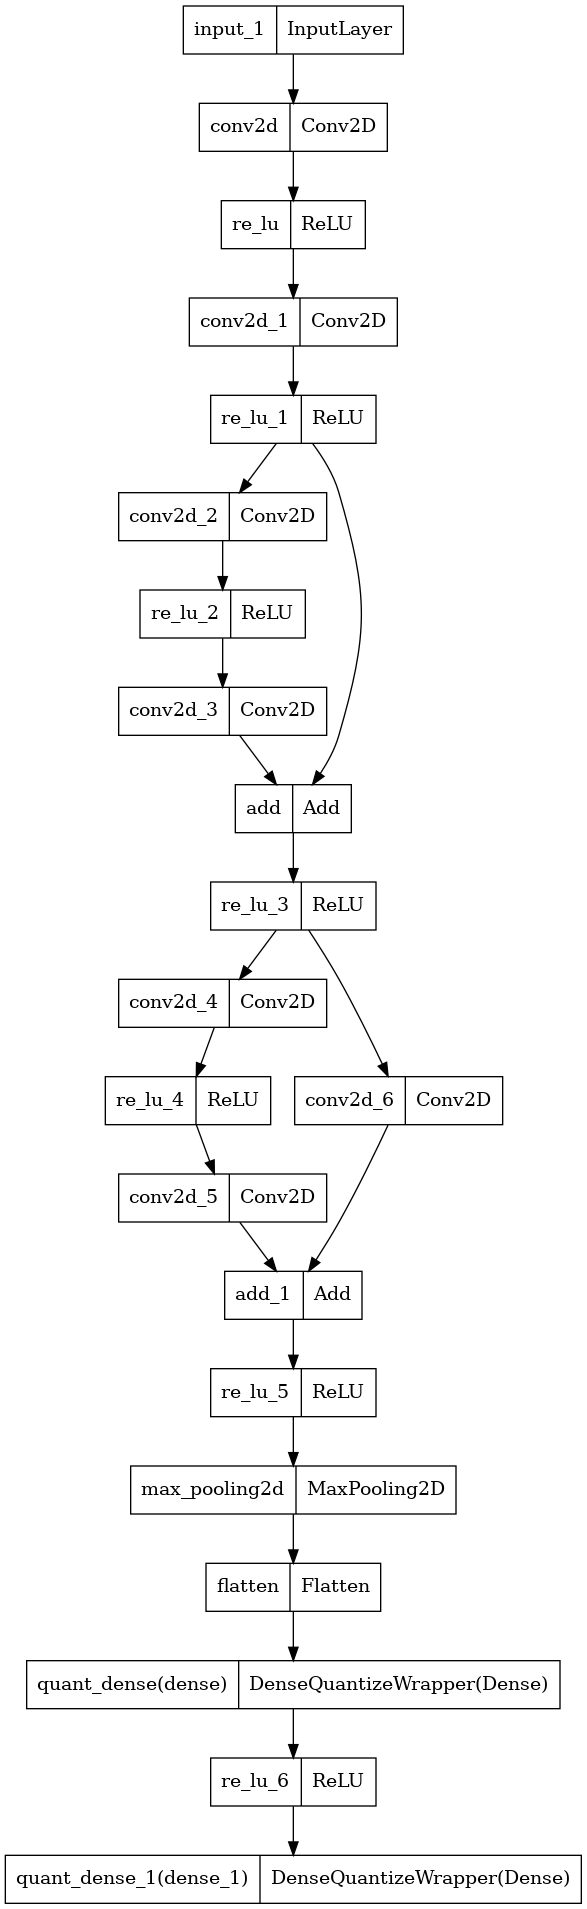

In [9]:
tf.keras.utils.plot_model(q_nn_model, to_file = assets.simple_network_quantize_specific_class.int8 + "/model.png")

In [10]:
# Fine-tune quantized model
fine_tune_epochs = 2
q_nn_model.fit(
    train_images,
    train_labels,
    batch_size=32,
    epochs=fine_tune_epochs,
    validation_split=0.1,
)
_, q_model_accuracy = q_nn_model.evaluate(test_images, test_labels, verbose=0)
q_model_accuracy = round(100 * q_model_accuracy, 2)
print(
    "Accuracy after fine tuning for {} epochs :{}".format(
        fine_tune_epochs, q_model_accuracy
    )
)

Epoch 1/2
1407/1407 [==============================] - 18s 13ms/step - loss: 0.9981 - accuracy: 0.6521 - val_loss: 1.0761 - val_accuracy: 0.6324
Epoch 2/2
1407/1407 [==============================] - 18s 13ms/step - loss: 0.9655 - accuracy: 0.6631 - val_loss: 1.0572 - val_accuracy: 0.6302
Accuracy after fine tuning for 2 epochs :61.82


In [11]:
# Save TF INT8 original model
tf.keras.models.save_model(q_nn_model, assets.simple_network_quantize_specific_class.int8_saved_model)

# Convert INT8 model to ONNX
utils.convert_saved_model_to_onnx(saved_model_dir = assets.simple_network_quantize_specific_class.int8_saved_model, onnx_model_path = assets.simple_network_quantize_specific_class.int8_onnx_model)

tf.keras.backend.clear_session()

INFO:tensorflow:Assets written to: /home/sagar/nvidia/2021/Customers/Waymo/QAT/tensorrt_qat/docs/source/notebooks/tutorial_onnx_models/simple_network_quantize_specific_class/int8/saved_model/assets


INFO:tensorflow:Assets written to: /home/sagar/nvidia/2021/Customers/Waymo/QAT/tensorrt_qat/docs/source/notebooks/tutorial_onnx_models/simple_network_quantize_specific_class/int8/saved_model/assets


ONNX conversion Done!


```{note}
ONNX files can be visualized with [Netron](https://netron.app/).
```